<a href="https://colab.research.google.com/github/umersajid11/CatDogClassification/blob/main/catdogclassificationusingdataaugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 97% 1.04G/1.06G [00:11<00:00, 225MB/s]
100% 1.06G/1.06G [00:11<00:00, 96.0MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os, shutil
from sklearn.model_selection import train_test_split

# Define source folders
base_dir = "/content/train"
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

# Get image file names
cat_images = [f for f in os.listdir(cat_dir) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_dir) if f.endswith('.jpg')]

# Split into train and val (90% train, 10% val)
cat_train, cat_val = train_test_split(cat_images, test_size=0.1, random_state=42)
dog_train, dog_val = train_test_split(dog_images, test_size=0.1, random_state=42)

# Create new folder structure
def make_dirs(base_path):
    for subset in ['train', 'val']:
        for label in ['cats', 'dogs']:
            path = os.path.join(base_path, subset, label)
            os.makedirs(path, exist_ok=True)

make_dirs('/content/data')

# Function to move images
def move_images(images, src_folder, dst_folder):
    for img in images:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.copyfile(src, dst)

# Move cat images
move_images(cat_train, cat_dir, '/content/data/train/cats')
move_images(cat_val, cat_dir, '/content/data/val/cats')

# Move dog images
move_images(dog_train, dog_dir, '/content/data/train/dogs')
move_images(dog_val, dog_dir, '/content/data/val/dogs')


In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Data Augmentation

In [8]:
# Preprocessing
image_size = (227, 227)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    fill_mode='nearest'
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
#Generator
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Since it's binary classification: cat vs dog
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [12]:
# Define the CNN model
model = Sequential()

# 1st Conv Block
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 227, 227, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 227, 227, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 113, 113, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 113, 113, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,455,009 (24.62 MB)

 Trainable params: 6,454,785 (24.62 MB)

 Non-trainable params: 224 (896.00 B)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

In [16]:
history = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[early_stop, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5572 - loss: 1.6999

563/563 ━━━━━━━━━━━━━━━━━━━━ 229s 391ms/step - accuracy: 0.5572 - loss: 1.6988 - val_accuracy: 0.6385 - val_loss: 0.6343
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6277 - loss: 0.6316

563/563 ━━━━━━━━━━━━━━━━━━━━ 212s 376ms/step - accuracy: 0.6277 - loss: 0.6315 - val_accuracy: 0.6895 - val_loss: 0.5874
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6848 - loss: 0.5834

563/563 ━━━━━━━━━━━━━━━━━━━━ 212s 376ms/step - accuracy: 0.6848 - loss: 0.5834 - val_accuracy: 0.7290 - val_loss: 0.5533
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7177 - loss: 0.5491

563/563 ━━━━━━━━━━━━━━━━━━━━ 211s 374ms/step - accuracy: 0.7177 - loss: 0.5491 - val_accuracy: 0.7295 - val_loss: 0.5153
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7429 - loss: 0.5119

563/563 ━━━━━━━━━━━━━━━━━━━━ 213s 379ms/step - accuracy: 0.7429 - loss: 0.5119 - val_accuracy: 0.7750 - val_loss: 0.4611
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7638 - loss: 0.4854

563/563 ━━━━━━━━━━━━━━━━━━━━ 211s 374ms/step - accuracy: 0.7638 - loss: 0.4854 - val_accuracy: 0.7790 - val_loss: 0.4582
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 214s 379ms/step - accuracy: 0.7803 - loss: 0.4570 - val_accuracy: 0.7485 - val_loss: 0.5100
Epoch 8/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 213s 379ms/step - accuracy: 0.7977 - loss: 0.4292 - val_accuracy: 0.7665 - val_loss: 0.4922
Epoch 9/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8186 - loss: 0.4062

563/563 ━━━━━━━━━━━━━━━━━━━━ 213s 378ms/step - accuracy: 0.8186 - loss: 0.4062 - val_accuracy: 0.7870 - val_loss: 0.4448
Epoch 10/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8275 - loss: 0.3831

563/563 ━━━━━━━━━━━━━━━━━━━━ 213s 379ms/step - accuracy: 0.8275 - loss: 0.3831 - val_accuracy: 0.8060 - val_loss: 0.4397
Epoch 11/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 215s 383ms/step - accuracy: 0.8425 - loss: 0.3616 - val_accuracy: 0.6530 - val_loss: 0.7545
Epoch 12/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8448 - loss: 0.3612

563/563 ━━━━━━━━━━━━━━━━━━━━ 215s 381ms/step - accuracy: 0.8448 - loss: 0.3612 - val_accuracy: 0.8580 - val_loss: 0.3241
Epoch 13/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 217s 385ms/step - accuracy: 0.8511 - loss: 0.3313 - val_accuracy: 0.8430 - val_loss: 0.3677
Epoch 14/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8579 - loss: 0.3295

563/563 ━━━━━━━━━━━━━━━━━━━━ 216s 383ms/step - accuracy: 0.8579 - loss: 0.3295 - val_accuracy: 0.8610 - val_loss: 0.3269
Epoch 15/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 217s 385ms/step - accuracy: 0.8680 - loss: 0.3158 - val_accuracy: 0.8430 - val_loss: 0.3660


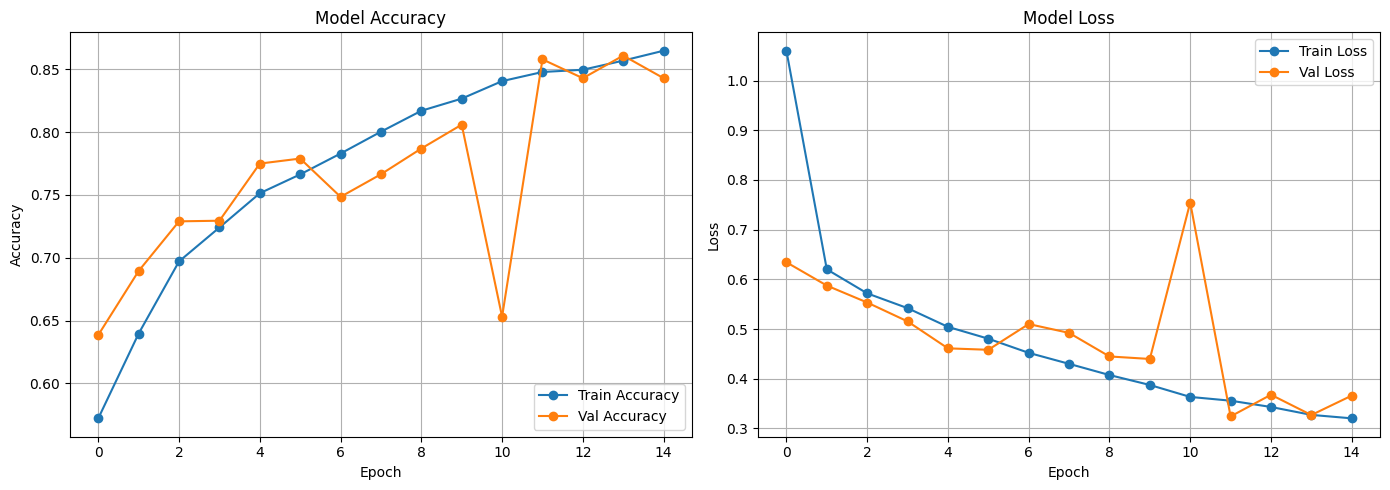

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
import numpy as np

val_loss = np.array(history.history['val_loss'])
train_loss = np.array(history.history['loss'])
val_acc = np.array(history.history['val_accuracy'])
train_acc = np.array(history.history['accuracy'])

# 1. Epochs where val_loss starts increasing
overfit_loss_epochs = np.where((val_loss[1:] > val_loss[:-1]) & (train_loss[1:] < train_loss[:-1]))[0] + 1

# 2. Epochs where val_accuracy drops while train_accuracy increases
overfit_acc_epochs = np.where((val_acc[1:] < val_acc[:-1]) & (train_acc[1:] > train_acc[:-1]))[0] + 1

# Combine unique epochs
overfitting_epochs = np.unique(np.concatenate((overfit_loss_epochs, overfit_acc_epochs)))

print("📌 Detected Overfitting Epochs:", overfitting_epochs if len(overfitting_epochs) > 0 else "None Detected ✅")


📌 Detected Overfitting Epochs: [ 6 10 12 14]


In [ ]:
#Way to Reduce Overfitting
#Add More Data
#Data AUgmentation
#L1/L2 Regulizer
#Dropout
#Batch Norm
#Reduce Complexity